https://blog.briankitano.com/llama-from-scratch/?utm_source=tldrai

In [43]:
import torch
from torch import nn
from torch.nn import functional as F
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import time
import pandas as pd

In [44]:
# torch.manual_seed(1337) # this seed is very lucky, it breaks the entire llama model
torch.manual_seed(175)
device = torch.device('cpu')
# device = torch.device('mps' if torch.backends.mps.is_available else 'cpu')
# if torch.cuda.is_available(): device = torch.device('cuda')

torch.set_default_device(device)

In [45]:
lines = open('./input.txt', 'r').read()

vocab = sorted(list(set(lines)))
itos = {i:ch for i, ch in enumerate(vocab)}
stoi = {ch:i for i, ch in enumerate(vocab)}

print(lines[:30])

First Citizen:
Before we proce


In [46]:
def encode(s):
    return [stoi[ch] for ch in s]

def decode(t):
    return ''.join(itos[i] for i in t)

print('vocab size:', len(vocab))
decode(encode('hello'))

vocab size: 65


'hello'

In [47]:
MASTER_CONFIG = {
    'vocab_size': len(vocab),
}

In [48]:
dataset = torch.tensor(encode(lines), dtype=torch.int8)
dataset.shape

torch.Size([1115394])

In [49]:
def get_batches(data, split, batch_size, context_window, config=MASTER_CONFIG):
    train = data[:int(.8 * len(data))]
    val = data[int(.8 * len(data)): int(.9 * len(data))]
    test = data[int(.9 * len(data)):]

    batch_data = train
    if split == 'val':
        batch_data = val
    if split == 'test':
        batch_data = test

    ix = torch.randint(0, batch_data.size(0) - context_window - 1, (batch_size,))
    x = torch.stack([batch_data[i:i + context_window] for i in ix]).long()
    y = torch.stack([batch_data[i + 1:i + context_window + 1] for i in ix]).long()

    return x.to(device), y.to(device)

MASTER_CONFIG.update({
    'batch_size': 32,
    'context_window': 16,
})

xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

[(decode(xs[i].tolist()), decode(ys[i].tolist())) for i in range(len(xs))]

[('dom,\nThat know n', 'om,\nThat know no'),
 ('est with,--\n\nShe', 'st with,--\n\nShep'),
 ('calps\nAgainst th', 'alps\nAgainst thy'),
 (', which\nGreat na', ' which\nGreat nat'),
 ('y,\nHis head by n', ',\nHis head by na'),
 (' lies\nFind writt', 'lies\nFind writte'),
 ('ve their voices;', 'e their voices; '),
 ("ndrakes' torn ou", "drakes' torn out"),
 (' mad:--\nO, if I ', 'mad:--\nO, if I w'),
 ('ood Camillo,\nShe', 'od Camillo,\nShe '),
 ("him be crown'd; ", "im be crown'd; i"),
 ('r word,\nOne nick', ' word,\nOne nick-'),
 ('\nThat we have ha', 'That we have had'),
 ('us;\nAnd now may ', 's;\nAnd now may s'),
 (' birds of prey,\n', 'birds of prey,\nA'),
 ('ow us\nhis wounds', 'w us\nhis wounds '),
 ('open ear, a quic', 'pen ear, a quick'),
 ('rs.\n\nPERDITA:\nOn', 's.\n\nPERDITA:\nOne'),
 ("'s hate\nI live t", 's hate\nI live to'),
 ('wife, but it\ndet', 'ife, but it\ndete'),
 ('ore I stay, the ', 're I stay, the m'),
 ('m: this is not, ', ': this is not, n'),
 (' grant that Wa

In [50]:
@torch.no_grad()
def evaluate_loss(model, config=MASTER_CONFIG):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = []
        for _ in range(10):
            xb, yb = get_batches(dataset, split, config['batch_size'], config['context_window'])
            _, loss = model(xb, yb)
            losses.append(loss.item())
        out[split] = np.mean(losses)
    model.train()
    return out

In [51]:
class SimpleBrokenModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super(SimpleBrokenModel, self).__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # numel = number of elements in tensor
        print('model params:', sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)
        # this should be call 'probs' since it comes from softmax, not 'logits'
        probs = F.softmax(a, dim=-1)

        if targets is not None:
            # print(probs.view(-1, self.config['vocab_size']).shape)
            # print(targets.view(-1).shape)
            loss = F.cross_entropy(probs.view(-1, self.config['vocab_size']), targets.view(-1))
            return probs, loss
        
        else:
            return probs
        
MASTER_CONFIG.update({
    'd_model': 128,
})
model = SimpleBrokenModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

probs, loss = model(xs, ys)

model params: 33217


model params: 33217
model: 10794100944
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


100%|██████████| 1000/1000 [00:04<00:00, 232.24it/s]

validation loss:  3.9495697736740114


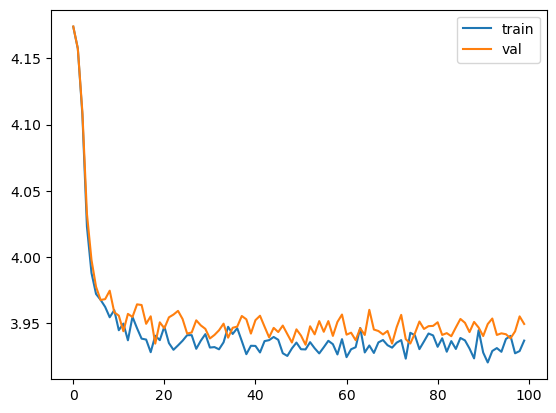

In [52]:
MASTER_CONFIG.update({
    'epochs': 1000,
    'log_interval': 10,
})
model = SimpleBrokenModel(MASTER_CONFIG).to(device)

optimizer = torch.optim.Adam(
    model.parameters()
)

def train(model, optimizer, scheduler=None, config=MASTER_CONFIG, print_logs=False):
    losses = []
    start_time = time.time()
    print(f"model: {id(model)}")
    print(f"printing devices:\n{[p.device for p in model.parameters()]}")

    for epoch in tqdm(range(config['epochs'])):
        optimizer.zero_grad()

        xs, ys = get_batches(dataset, 'train', config['batch_size'], config['context_window'])
        probs, loss = model(xs, targets=ys)
        loss.backward()
        optimizer.step()

        if scheduler:
            scheduler.step()
        
        if epoch % config['log_interval'] == 0:
            batch_time = time.time() - start_time
            x = evaluate_loss(model)
            losses.append(x)
            if print_logs:
                print(f"Epoch {epoch} | val loss {x['val']:.3f} | Time {batch_time:.3f} | ETA in seconds {batch_time * (config['epochs'] - epoch)/config['log_interval']:.3f}")
            start_time = time.time()

            if scheduler:
                print(f"LR: {scheduler.get_lr()}")
    
    print('validation loss: ', losses[-1]['val'])
    pd.DataFrame(losses).plot()

train(model, optimizer, print_logs=False)

In [53]:
'''
Beautiful.
'''
model.to(device)
model.eval()

sentence = 'Romeo thou art my love '
output = model(torch.tensor(encode(sentence)).to(device))
preds = torch.argmax(output, dim=1)

print(output.shape)
print(preds)
print(decode(preds.tolist()))

torch.Size([23, 65])
tensor([21, 59, 43,  1, 59, 58, 46, 43, 59, 56, 58, 52,  1, 46, 58, 43,  1, 58,
         1, 59, 43,  1, 58])
Iue utheurtn hte t ue t


model params: 33217
model: 10853426704
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


100%|██████████| 1000/1000 [00:03<00:00, 261.25it/s]


validation loss:  2.5316060304641725


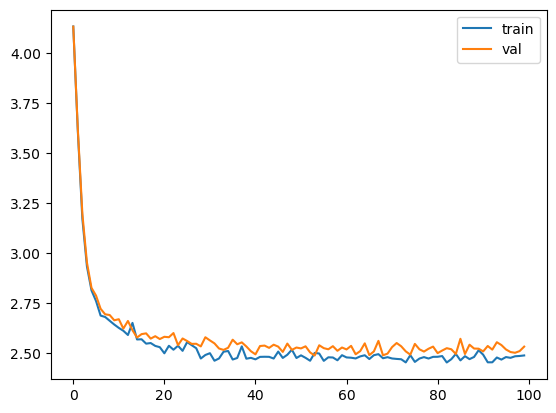

In [54]:
class SimpleModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super(SimpleModel, self).__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # numel = number of elements in tensor
        print('model params:', sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        a = self.linear(x)

        if targets is not None:
            # print(a.view(-1, self.config['vocab_size']).shape)
            # print(targets.view(-1).shape)
            loss = F.cross_entropy(a.view(-1, self.config['vocab_size']), targets.view(-1))
            return a, loss
        
        else:
            return a
        
model = SimpleModel(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

a, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())

train(model, optimizer)

In [55]:
'''
A bit better.
'''
model.to(device)
model.eval()

sentence = 'Romeo thou art my love '
output = model(torch.tensor(encode(sentence)).to(device))
preds = torch.argmax(output, dim=1)

print(output.shape)
print(preds)
print(decode(preds.tolist()))

torch.Size([23, 65])
tensor([16, 59, 43,  1, 59, 58, 46, 43, 59, 56, 58, 52, 43, 46, 58, 43,  1, 58,
        50, 59, 43,  1, 58])
Due utheurtnehte tlue t


In [93]:
print(MASTER_CONFIG)
print(type(model))

{'vocab_size': 65, 'batch_size': 32, 'context_window': 16, 'd_model': 128, 'epochs': 10000, 'log_interval': 10, 'n_heads': 8, 'n_layers': 4}
<class '__main__.RopeModel'>


In [89]:
def generate(model, config=MASTER_CONFIG, max_new_tokens=30):
    idx = torch.zeros(5, 16).long()
    # print(f"-------: {idx[:, -config['context_window']:].shape}")
    for _ in tqdm(range(max_new_tokens)):
        logits = model(idx[:, -config['context_window']:])
        last_time_step_logits = logits[:, -1, :]
        p = F.softmax(last_time_step_logits, dim=-1)
        idx_next = torch.multinomial(p, num_samples=1)
        idx = torch.cat([idx, idx_next], dim=-1)
    return [decode(x) for x in idx.tolist()]

generate(model)

100%|██████████| 30/30 [00:00<00:00, 604.13it/s]


['\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nLADindsens.\n\nBUCKINGHMBROLTHUM',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nISCARGELOUMEO:\nOnimisteno;\nOr ',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nKING EDWARD IV:\nWill worst as ',
 '\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nSOF YORK:\nI will of me: the br',
 "\n\n\n\n\n\n\n\n\n\n\n\n\n\n\n\nHLORIA:\nI'ded pene?\n\nWARWICK:\n"]

In [57]:
class RMSNorm(nn.Module):
    def __init__(self, layer_shape, eps=1e-8, bias=False):
        super(RMSNorm, self).__init__()
        self.register_parameter('scale', nn.Parameter(torch.ones(layer_shape)))
    
    def forward(self, x):
        """ 
        l2-norm on dim=(1,2) is the euclidean distance from the origin
        for the context_window x d_model matrix

        x[0].numel() ** -0.5 is the scale factor relative to the number 
        of elements in the matrix
        """
        ff_rms = torch.linalg.norm(x, dim=(1,2)) * x[0].numel() ** -0.5
        raw = x / ff_rms.unsqueeze(-1).unsqueeze(-1)
        # print(ff_rms.shape)
        # print(raw.shape)
        # print(f"scale unsqueeze: {self.scale[:x.shape[1], :].unsqueeze(0).shape}")
        return self.scale[:x.shape[1], :].unsqueeze(0) * raw
    
config = {
    'batch_size': 5,
    'context_window': 11,
    'd_model': 13,
}
batch = torch.randn(config['batch_size'], config['context_window'], config['d_model']).to(device)
m = RMSNorm((config['context_window'], config['d_model'])).to(device)
g = m(batch)
print(g.shape)

torch.Size([5, 11, 13])


In [58]:
'''
Up to here we implemented simple embedding and linear models to
predict the next character in a sentence.

The next step here is to implement Llama. So far we have implemented
a RMSNorm function and left off at verifying that it does what it should be doing.

RMS = take the squared mean of the elements, and square root it
'''
rms = torch.linalg.norm(batch, dim=(1,2)) * (batch[0].numel() ** -0.5)

assert torch.linalg.norm( torch.arange(5).float() ) == (torch.arange(5).float() ** 2 ).sum() ** .5
rms = torch.linalg.norm( torch.arange(5).float() ) * (torch.arange(5).numel() ** -0.5)
assert torch.allclose( torch.linalg.norm(torch.arange(5).float() / rms), torch.tensor(5 ** .5))
ff_rms = torch.linalg.norm(batch, dim=(1,2)) * batch.shape[1:].numel() ** -0.5

# RMS
ffx = torch.zeros_like(batch)
for i in range(batch.shape[0]):
    ffx[i] = batch[i] / ff_rms[i]
assert torch.allclose(torch.linalg.norm(ffx, dim=(1,2)) ** 2, torch.tensor(143).float())
assert torch.allclose(ffx, g)

model params: 35265
model: 10794014224
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


100%|██████████| 1000/1000 [00:04<00:00, 214.61it/s]


validation loss:  2.5091559171676634


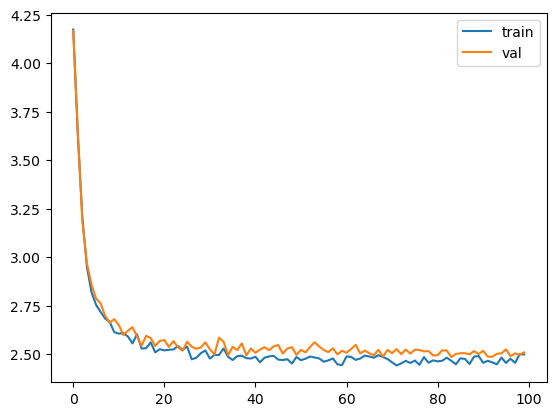

In [59]:
class SimpleModel_RMS(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        # numel = number of elements in tensor
        print('model params:', sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.rms(x)
        # logit: abuse of notation
        # https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow#:~:text=The%20logit%20(%2F%CB%88lo%CA%8Ad%CA%92%C9%AAt%2F%20LOH,p%2F(1%20%E2%88%92%20p).
        logit = self.linear(x)

        if targets is not None:
            # print(logit.view(-1, self.config['vocab_size']).shape)
            # print(targets.view(-1).shape)
            loss = F.cross_entropy(logit.view(-1, self.config['vocab_size']), targets.view(-1))
            return logit, loss
        
        else:
            return logit
        

model = SimpleModel_RMS(MASTER_CONFIG).to(device)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [60]:
def get_rotary_matrix(context_window, embedding_dim):
    R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
    for position in range(context_window):
        for i in range(embedding_dim // 2):
            theta = 10000. ** (-2.*(i - 1) / embedding_dim)
            m_theta = position * theta
            R[position, 2*i, 2*i] = torch.cos(torch.tensor(m_theta)).item()
            R[position, 2*i, 2*i+1] = -torch.sin(torch.tensor(m_theta)).item()
            R[position, 2*i+1, 2*i] = torch.sin(torch.tensor(m_theta)).item()
            R[position, 2*i+1, 2*i+1] = torch.cos(torch.tensor(m_theta)).item()
    return R

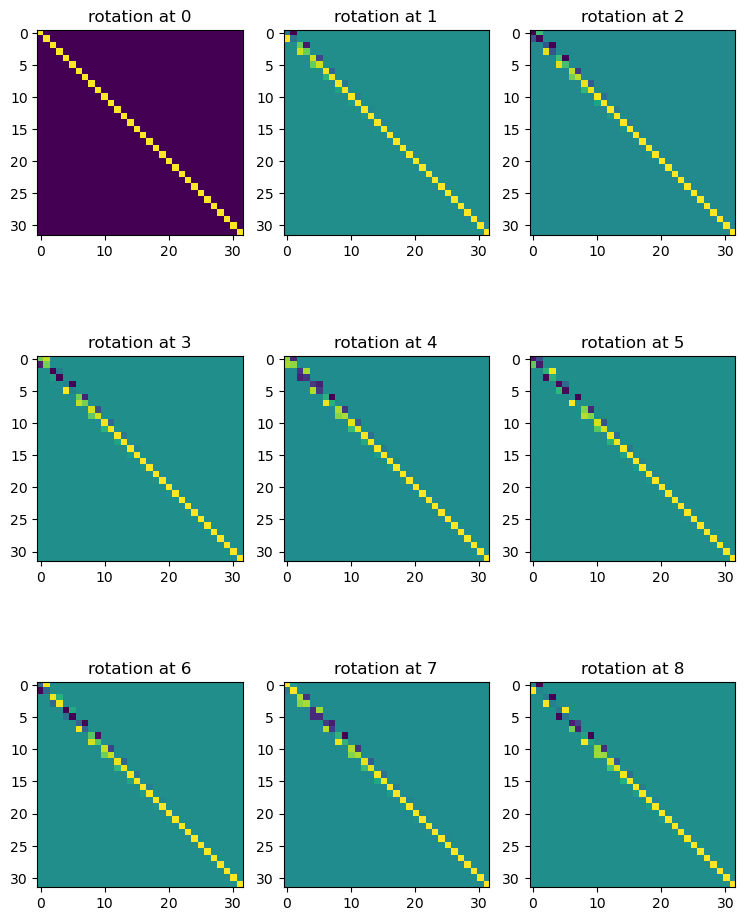

In [61]:
K = 3
config = {
    'batch_size': 10,
    'd_model': 32,
    'n_heads': 8,
    'context_window': K**2,
}
batch = torch.randn(1, config['context_window'], config['d_model'])
R = get_rotary_matrix(config['context_window'], config['d_model'])
fig, ax = plt.subplots(K, K, figsize=(K * 3, K * 4))

for i in range(K):
    for j in range(K):
        ax[i, j].imshow(R[i * K + j].detach().cpu().numpy())
        ax[i, j].set_title(f'rotation at {i * K + j}')

In [62]:
config = {
    'batch_size': 10,
    'd_model': 512,
    'n_heads': 8,
    'context_window': 16,
}

class RoPEAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    @staticmethod
    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i, 2*i] = torch.cos(torch.tensor(m_theta)).item()
                R[position, 2*i, 2*i+1] = -torch.sin(torch.tensor(m_theta)).item()
                R[position, 2*i+1, 2*i] = torch.sin(torch.tensor(m_theta)).item()
                R[position, 2*i+1, 2*i+1] = torch.cos(torch.tensor(m_theta)).item()
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # bmm = batch by batch matrix multiplication
        q_out = (torch.bmm(q.transpose(0, 1), self.R)).transpose(0, 1)
        k_out = (torch.bmm(k.transpose(0, 1), self.R)).transpose(0, 1)
        v_out = (torch.bmm(v.transpose(0, 1), self.R)).transpose(0, 1)

        activations, attn_weights = self.multihead(q_out, k_out, v_out)

        if return_attn_weights:
            return activations, attn_weights
        return activations

# this just takes approx 5min to run...
layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [63]:
x = torch.randn((config['batch_size'], config['context_window'], config['d_model']))

q = layer.w_q(x)
k = layer.w_k(x)
v = layer.w_v(x)

q_rotated = torch.zeros_like(q)
k_rotated = torch.zeros_like(k)
v_rotated = torch.zeros_like(v)

for position in range(config['context_window']):
    q_rotated[:, position, :] = torch.matmul(q[:, position, :], layer.R[position,:,:])
    k_rotated[:, position, :] = torch.matmul(k[:, position, :], layer.R[position,:,:])
    v_rotated[:, position, :] = torch.matmul(v[:, position, :], layer.R[position,:,:])

q_out = (torch.bmm(q.transpose(0,1), layer.R)).transpose(0,1)
k_out = (torch.bmm(k.transpose(0,1), layer.R)).transpose(0,1)
v_out = (torch.bmm(v.transpose(0,1), layer.R)).transpose(0,1)

assert torch.allclose(q.transpose(0,1)[0], q[:,0,:])
assert torch.allclose(q.transpose(0,1)[0] @ layer.R[0], q[:,0,:] @ layer.R[0])
assert torch.allclose(q_rotated, q_out)

In [64]:
config = {
    'batch_size': 1,
    'd_model': 2,
    'n_heads': 2,
    'context_window': 3,
}

layer = RoPEAttention(config)
batch = torch.ones((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

m = 0
x_q = batch[0, m]
q = layer.R[m,:,:] @ layer.w_q(x_q)

assert torch.allclose(layer.w_q(x_q), layer.w_q.weight @ x_q)
assert torch.allclose(q, layer.R[m,:,:] @ layer.w_q.weight @ x_q)

n = 2
x_k = batch[0, n]
k = layer.R[n,:,:] @ layer.w_k(x_k)

assert torch.allclose(layer.w_k(x_k), layer.w_k.weight @ x_k)
assert torch.allclose(k, layer.R[n,:,:] @ layer.w_k.weight @ x_k)

assert q.T @ k == q @ k
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n,:,:].T @ layer.R[m,:,:] @ layer.w_q.weight @ x_q)
assert torch.allclose(q @ k, x_k.T @ layer.w_k.weight.T @ layer.R[n-m,:,:].T @ layer.w_q.weight @ x_q)

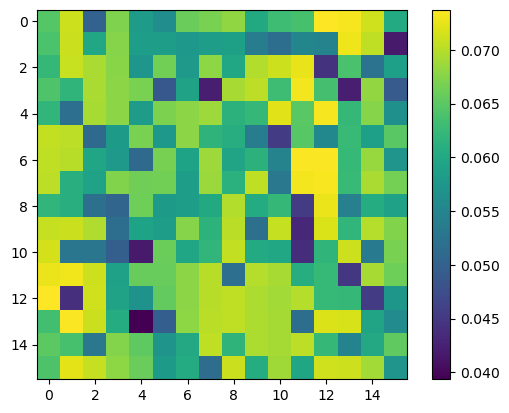

In [65]:
MASTER_CONFIG.update({
    'n_heads': 8,
})
layer = RoPEAttention(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().cpu().numpy(), interpolation='nearest')
plt.colorbar()

In [96]:
class RoPEAttention_wMask(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.w_q = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_k = nn.Linear(config['d_model'], config['d_model'], bias=False)
        self.w_v = nn.Linear(config['d_model'], config['d_model'], bias=False)

        self.multihead = nn.MultiheadAttention(config['d_model'], config['n_heads'], dropout=0.1, batch_first=True)
        self.R = get_rotary_matrix(config['context_window'], config['d_model'])

    def get_rotary_matrix(context_window, embedding_dim):
        R = torch.zeros((context_window, embedding_dim, embedding_dim), requires_grad=False)
        for position in range(context_window):
            for i in range(embedding_dim // 2):
                theta = 10000. ** (-2.*(i - 1) / embedding_dim)
                m_theta = position * theta
                R[position, 2*i, 2*i] = torch.cos(torch.tensor(m_theta)).item()
                R[position, 2*i, 2*i+1] = -torch.sin(torch.tensor(m_theta)).item()
                R[position, 2*i+1, 2*i] = torch.sin(torch.tensor(m_theta)).item()
                R[position, 2*i+1, 2*i+1] = torch.cos(torch.tensor(m_theta)).item()
        return R

    def forward(self, x, return_attn_weights=False):
        b, m, d = x.shape

        q = self.w_q(x)
        k = self.w_k(x)
        v = self.w_v(x)

        # bmm = batch by batch matrix multiplication
        q_out = (torch.bmm(q.transpose(0, 1), self.R[:m, ...])).transpose(0, 1)
        k_out = (torch.bmm(k.transpose(0, 1), self.R[:m, ...])).transpose(0, 1)
        v_out = (torch.bmm(v.transpose(0, 1), self.R[:m, ...])).transpose(0, 1)

        activations, attn_weights = self.multihead(
            q_out, k_out, v_out,
            attn_mask=nn.Transformer.generate_square_subsequent_mask(m),
            is_causal=True
        )

        if return_attn_weights:
            return activations, attn_weights
        return activations

layer = RoPEAttention(config)
batch = torch.randn((config['batch_size'], config['context_window'], config['d_model']))
output, attn_weights = layer(batch, return_attn_weights=True)

In [97]:
print(torch.backends.mps.is_available())

True


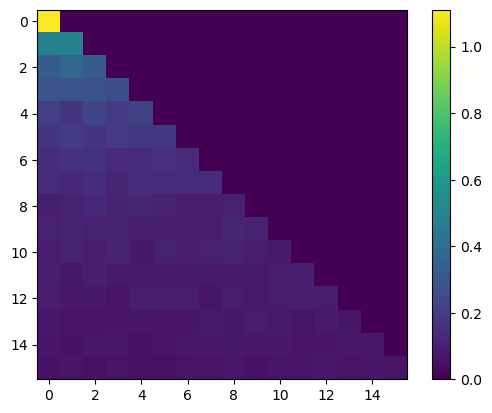

In [98]:
layer = RoPEAttention_wMask(MASTER_CONFIG)
batch = torch.ones((MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model'])).to(device)
output, attn_weights = layer(batch, return_attn_weights=True)

plt.imshow(attn_weights[0].detach().numpy())
plt.colorbar()

model params: 150465
model: 10878725328
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


100%|██████████| 10000/10000 [02:54<00:00, 57.16it/s]

validation loss:  1.900049340724945
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


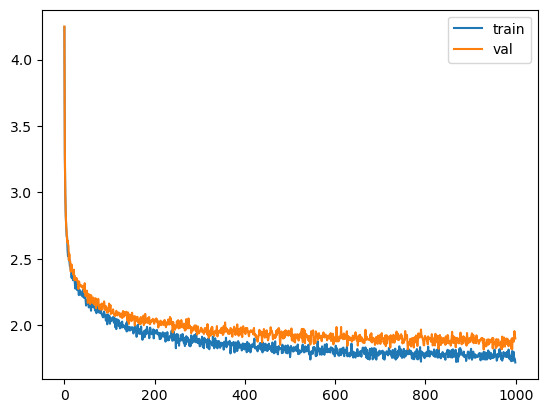

In [99]:
class RoPEModel(nn.Module):
    def __init__(self, config=MASTER_CONFIG):
        super().__init__()
        self.config = config

        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            nn.ReLU(),
        )

        self.last_layer = nn.Linear(config['d_model'], config['vocab_size'])

        # numel = number of elements in tensor
        print('model params:', sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        # apply rms normalization before each layer
        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        # logit: abuse of notation
        # https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow#:~:text=The%20logit%20(%2F%CB%88lo%CA%8Ad%CA%92%C9%AAt%2F%20LOH,p%2F(1%20%E2%88%92%20p).
        logit = self.last_layer(x)

        if targets is not None:
            # print(logit.view(-1, self.config['vocab_size']).shape)
            # print(targets.view(-1).shape)
            loss = F.cross_entropy(logit.view(-1, self.config['vocab_size']), targets.view(-1))
            return logit, loss
        
        else:
            return logit

model = RoPEModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)
print(f"printing devices:\n{[p.device for p in model.parameters()]}")


model: 10878725328
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


100%|██████████| 5000/5000 [01:26<00:00, 57.74it/s]

validation loss:  1.849277174472809


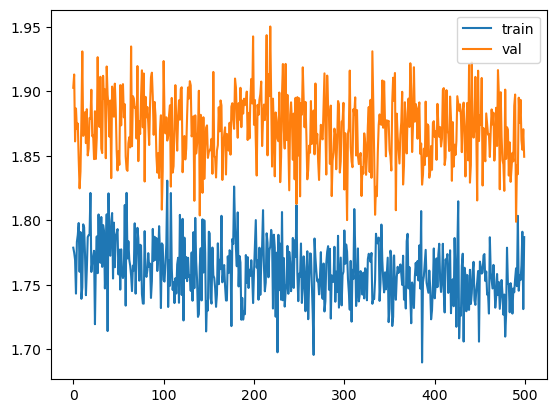

In [100]:
MASTER_CONFIG.update({
    'epochs': 5000,
    'log_interval': 10,
})
train(model, optimizer)

In [101]:
class SwiGLU(nn.Module):
    """
    Swish-Gated Linear Unit
    https://arxiv.org/pdf/2002.05202v1.pdf
    """
    def __init__(self, size):
        super().__init__()
        self.config = config
        self.linear_gate = nn.Linear(size, size)
        self.linear = nn.Linear(size, size)
        self.beta = torch.randn(1, requires_grad=True)

        self.beta = nn.Parameter(torch.ones(1))
        self.register_parameter('beta', self.beta)

    def forward(self, x):
        swish_gate = self.linear_gate(x) * torch.sigmoid(self.beta * self.linear_gate(x))
        out = swish_gate * self.linear(x)
        return out

model params: 183490
model: 10879622224
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu')]


100%|██████████| 5000/5000 [01:37<00:00, 51.26it/s]


validation loss:  1.8395379304885864


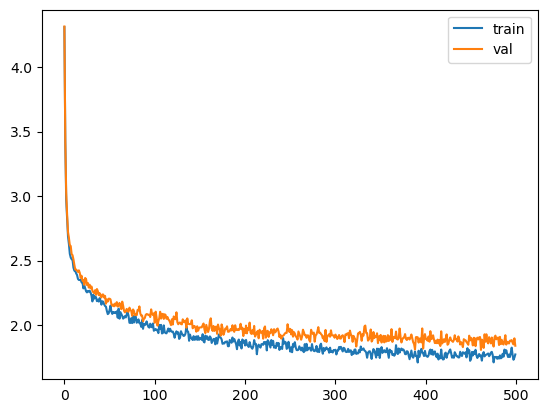

In [102]:
class RopeModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.rope_attention = RoPEAttention_wMask(config)

        self.linear = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

        self.last_linear = nn.Linear(config['d_model'], config['vocab_size'])

        print("model params:", sum([m.numel() for m in self.parameters()]))
    
    def forward(self, idx, targets=None):
        x = self.embedding(idx)

        x = self.rms(x)
        x = x + self.rope_attention(x)

        x = self.rms(x)
        x = x + self.linear(x)

        logits = self.last_linear(x)

        if targets is not None:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
        else:
            return logits
        
model = RopeModel(MASTER_CONFIG)
xs, ys = get_batches(dataset, 'train', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])

logits, loss = model(xs, ys)
optimizer = torch.optim.Adam(model.parameters())
train(model, optimizer)

In [103]:
# add RMSNorm and residual connection
class LlamaBlock(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.rms = RMSNorm((config['context_window'], config['d_model']))
        self.attention = RoPEAttention_wMask(config)
        self.feedforward = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
        )

    def forward(self, x):
        x = self.rms(x)
        x = x + self.attention(x)

        x = self.rms(x)
        x = x + self.feedforward(x)
        return x

In [104]:
block = LlamaBlock(MASTER_CONFIG)
block(torch.randn(MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'], MASTER_CONFIG['d_model']))

tensor([[[ 0.2254,  0.1727, -1.6976,  ...,  2.0486, -1.7986,  1.2645],
         [-0.6076,  1.5451,  1.2235,  ..., -0.1380, -0.2661, -0.1431],
         [ 0.1215, -0.2148,  1.7832,  ...,  0.0371, -2.9525,  0.8871],
         ...,
         [-0.6222, -0.5003, -0.5295,  ..., -1.6171,  0.3626,  0.4475],
         [-1.0895,  2.0465, -1.4941,  ..., -0.4807, -0.6796, -1.3168],
         [ 2.9876, -1.0403, -0.0655,  ..., -1.6118, -0.0960,  1.3506]],

        [[-0.2508, -1.4545,  1.7372,  ...,  0.5788,  2.6727,  0.0587],
         [-0.0616,  0.3076,  0.7122,  ..., -2.5407,  2.2955, -0.6875],
         [-0.1697, -1.7802,  0.1122,  ...,  0.5028,  1.2827,  0.1549],
         ...,
         [ 1.3257, -0.0187, -1.0498,  ..., -1.2256, -1.6886, -1.0371],
         [-1.9479,  0.8134,  0.3958,  ..., -1.2786,  0.3682, -1.4173],
         [ 0.8002,  0.8226, -0.1050,  ...,  0.2252,  0.9859,  0.4261]],

        [[ 1.2475, -2.9742,  0.1945,  ...,  1.9715,  1.5821, -0.8879],
         [ 0.8228,  2.0854, -0.3227,  ...,  0

model params: 733382
model: 10879417360
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), d

100%|██████████| 5000/5000 [37:32<00:00,  2.22it/s]    

validation loss:  1.5766579508781433


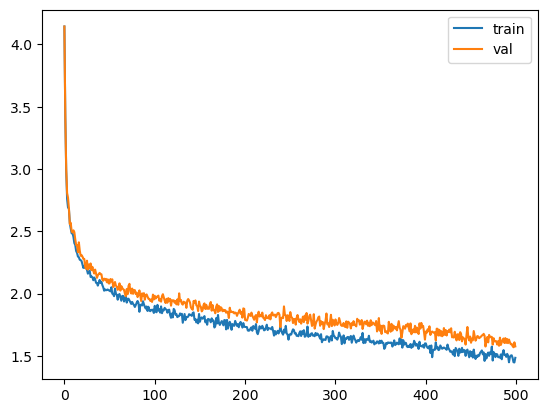

In [105]:
from collections import OrderedDict

MASTER_CONFIG.update({
    'n_layers': 4,
})
class Llama(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        self.embedding = nn.Embedding(config['vocab_size'], config['d_model'])
        self.llama_blocks = nn.Sequential(
            OrderedDict([(f"llama_{i}", LlamaBlock(config)) for i in range(config['n_layers'])])
        )

        self.ffn = nn.Sequential(
            nn.Linear(config['d_model'], config['d_model']),
            SwiGLU(config['d_model']),
            nn.Linear(config['d_model'], config['vocab_size']),
        )

        print("model params:", sum([m.numel() for m in self.parameters()]))

    def forward(self, idx, targets=None):
        x = self.embedding(idx)
        x = self.llama_blocks(x)
        logits = self.ffn(x)

        if targets is None:
            return logits
        
        else:
            loss = F.cross_entropy(logits.view(-1, self.config['vocab_size']), targets.view(-1))
            return logits, loss
        
llama = Llama(MASTER_CONFIG)
optimizer = torch.optim.Adam(llama.parameters())
train(llama, optimizer, config=MASTER_CONFIG)

In [106]:
MASTER_CONFIG.update({
    'epochs': 10000,
})
train(llama, optimizer, scheduler=None, config=MASTER_CONFIG)

model: 10879417360
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), de

 63%|██████▎   | 6269/10000 [2:30:30<04:34, 13.60it/s]     

model: 10853393616
printing devices:
[device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), device(type='cpu'), de

100%|██████████| 10000/10000 [12:20<00:00, 13.50it/s]


validation loss:  0.685124397277832


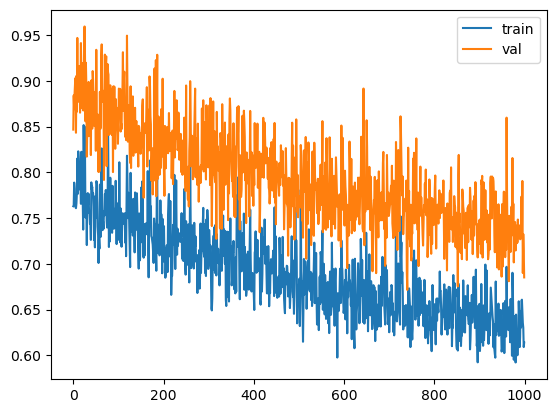

In [ ]:
train(llama, optimizer, config=MASTER_CONFIG)

In [ ]:
torch.save(model.state_dict(), 'llama.pt')

In [ ]:
print(generate(llama, MASTER_CONFIG, 500)[0])

100%|██████████| 500/500 [00:02<00:00, 198.83it/s]

















OROMOPSON:
Wishous.

Your:
When aunder loving flaint ment ranishal Can stongity and is love
Reve my chard 't swith hily say to the treesy
But and is his lay worn thereous, it all hencely freer thuson
As the flayly
Offols on lass; pruful
God to my swimes, too with in thy or miay post is confel wast:
Thave pass, foul we losse! O he vagalent this;
Cit wrippy as their ba you
As had?
I, so test.

Of the I'ld un canked vyself, and but a't! 'tway: e'er love what that save of doe for ribem, the ded
Him 


In [ ]:
xs, ys = get_batches(dataset, 'test', MASTER_CONFIG['batch_size'], MASTER_CONFIG['context_window'])
logits, loss = llama(xs, ys)
print(loss)